<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Creating-village-network" data-toc-modified-id="Creating-village-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating village network</a></span><ul class="toc-item"><li><span><a href="#Compute-correlation-coefficient/linear-regression-on-centrality-measures" data-toc-modified-id="Compute-correlation-coefficient/linear-regression-on-centrality-measures-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Compute correlation coefficient/linear regression on centrality measures</a></span></li><li><span><a href="#Plot-graphs-colored-by-centrality" data-toc-modified-id="Plot-graphs-colored-by-centrality-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot graphs colored by centrality</a></span></li></ul></li><li><span><a href="#Animation-of-KNN-graphs" data-toc-modified-id="Animation-of-KNN-graphs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Animation of KNN graphs</a></span></li><li><span><a href="#Compare-Centralities" data-toc-modified-id="Compare-Centralities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare Centralities</a></span><ul class="toc-item"><li><span><a href="#Run-champ-to-identify-communities-in-the-village-network" data-toc-modified-id="Run-champ-to-identify-communities-in-the-village-network-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Run champ to identify communities in the village network</a></span></li></ul></li></ul></div>

# Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mc
import matplotlib.cm as cm
import pandas as pd
import os,sys,re
import network_tools as nt
import graph_tool as gt
import graph_tool.centrality as gtc
import graph_tool.draw as gtd
import graph_tool.topology as gtt
import seaborn as sbn
import scipy.stats as stats
import scipy
import champ
import statsmodels.api as sm
import seaborn as sbn
import imageio


datadir="data/python_import"
os.listdir(datadir)

graphics_dir=os.path.join("graphics")
if not os.path.exists(graphics_dir):
    os.makedirs(graphics_dir)

In [8]:
os.listdir(datadir)

['voroniterritories_covariates_38x.csv',
 'cluster_inbreedinf_coefficient_results_351x.csv',
 'raw_pairwise_ibD_long_mtdt.csv',
 'networks',
 'distancematrix_bycluster.csv',
 'clust_covariates_351x.csv',
 'voroniterritories_inbreedinf_coefficient_results_38x.csv',
 'voroni_migration_flows_fromworldpop.csv',
 'cd2013_geopos.csv']

In [9]:
#some functions
def create_knn_from_distmat(dist_mat, k, weight_func=None):
    """Given input DISTANCE matrix, construct the knn adjacency with possible weight function on values (otherwise
    all weights are 1).  Simple implementation. Doesn't scale well.  """
    n = dist_mat.shape[0]
    #     out_adj = sparse.csr_matrix((n, n))
    out_adj = np.zeros((n, n))
    for i in range(n):
#         closest_inds = np.argpartition(np.array(dist_mat[i, :]), -1*(k + 1))[-k-1:] #finds minimum distance for rows
        if k>0:
            closest_inds = np.argpartition(np.array(dist_mat[i, :]), k + 1)[:k+1] #finds minimum distance for rows
        else:
            closest_inds=np.arange(n) #full connected graph
        
        closest_inds = closest_inds[closest_inds != i]  # no self edges
        
#         closest_inds = [x for x in closest_inds if dist_mat[i, x] > 0] # make sure 0 values aren't included
        # print(i,len(closest_inds))
        if weight_func is None:
            out_adj[i, closest_inds] = 1
            out_adj[closest_inds, i] = 1
        else:
            vals = np.array(list(map(lambda x : weight_func(x), dist_mat[i, closest_inds])))
            for j,ind in enumerate(closest_inds):
                out_adj[i, ind] = vals[j]
                out_adj[ind, i] = vals[j]
    return out_adj

In [10]:
os.listdir(datadir)

['voroniterritories_covariates_38x.csv',
 'cluster_inbreedinf_coefficient_results_351x.csv',
 'raw_pairwise_ibD_long_mtdt.csv',
 'networks',
 'distancematrix_bycluster.csv',
 'clust_covariates_351x.csv',
 'voroniterritories_inbreedinf_coefficient_results_38x.csv',
 'voroni_migration_flows_fromworldpop.csv',
 'cd2013_geopos.csv']

In [11]:
meta_data=pd.read_csv(os.path.join(datadir,"clust_covariates_351x.csv"),index_col=1)
finbd_df=pd.read_csv(os.path.join(datadir,'cluster_inbreedinf_coefficient_results_351x.csv'))

for ind in finbd_df.index:
    col="Finbd_{:}".format(finbd_df.loc[ind,'spacetype'])
    meta_data.loc[finbd_df.loc[ind,'hv001'],col]=finbd_df.loc[ind,'Finbd']


dist_adj_long=pd.read_csv(os.path.join(datadir,"distancematrix_bycluster.csv"))


dist_adj_long=dist_adj_long.iloc[np.where(np.logical_and(dist_adj_long.loc[:,'hv001.x'].isin(meta_data.index),
               dist_adj_long.loc[:,'hv001.y'].isin(meta_data.index)))[0],:]



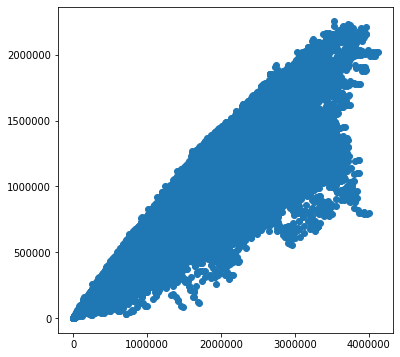

In [12]:
#distance from coordiances with gc distance

plt.close()
f,a=plt.subplots(1,1,figsize=(6,6))
a.scatter(dist_adj_long.loc[:,'roaddistance'],dist_adj_long.loc[:,'gcdistance'])

plt.show()

In [13]:
#old datafiles
# ibd_dists=pd.read_csv(os.path.join(datadir,"ibD_adjancency_matrix_long.csv"))
# meta_data=pd.read_csv(os.path.join(datadir,"metadata_features.csv"),index_col=0)
# dist_adj_long=pd.read_csv(os.path.join(datadir,'..',"distance_adjacency_matrix_long.csv"))

# Creating village network

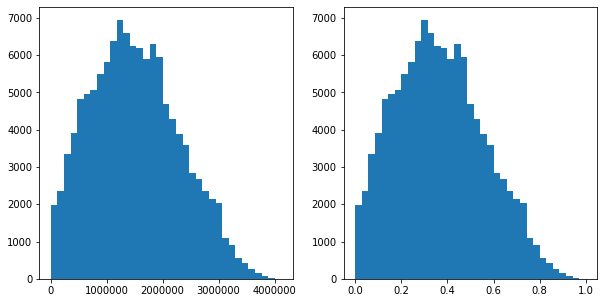

In [14]:
plt.close()
f,a=plt.subplots(1,2,figsize=(10,5))
a[0].hist(dist_adj_long['roaddistance'],bins=35)
a[1].hist(dist_adj_long['roaddistance']/dist_adj_long['roaddistance'].max(),bins=35)

plt.show()

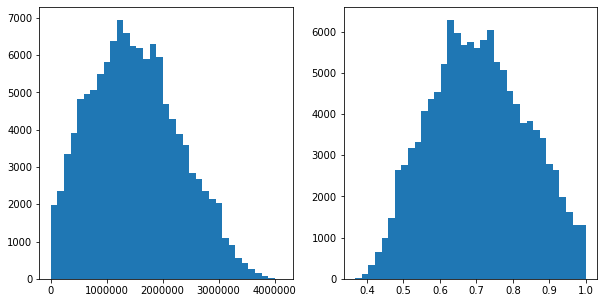

In [15]:
plt.close()
f,a=plt.subplots(1,2,figsize=(10,5))
a[0].hist(dist_adj_long['roaddistance'],bins=35)
a[1].hist(np.exp(-1*dist_adj_long['roaddistance']/dist_adj_long['roaddistance'].max()),bins=35)

plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


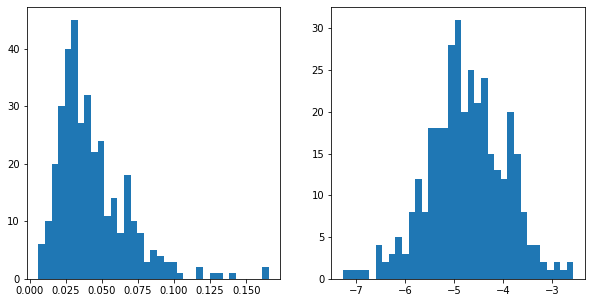

In [16]:
plt.close()
f,a=plt.subplots(1,2,figsize=(10,5))
a[0].hist(meta_data['Finbd_roaddist'],bins=35)
a[1].hist(np.log2(meta_data['Finbd_gcdist']),bins=35)

plt.show()

In [17]:
meta_data

,adm1name,latnum,longnum,geometry,incidence,urban,Finbd_gcdist,Finbd_roaddist
hv001,,,,,,,,
1,Tshuapa,0.220128,21.795078,"c(21.795078, 0.220128)",0.347717,-0.311404,0.029510,0.030874
2,Equateur,0.529766,19.203205,"c(19.203205, 0.529766)",0.346010,-0.627742,0.037510,0.044126
3,Kinshasa,-4.396131,15.352401,"c(15.352401, -4.396131)",NaN,NaN,NaN,NaN
4,Kwilu,-4.386094,18.065496,"c(18.065496, -4.386094)",NaN,NaN,NaN,NaN
5,Sud-Kivu,-2.960349,28.527202,"c(28.527202, -2.960349)",0.206816,-1.112527,0.024862,0.022708
6,Ituri,1.752020,30.217535,"c(30.217535, 1.75202)",0.452804,1.611762,0.044975,0.042011
7,Kinshasa,-4.338141,15.284108,"c(15.284108, -4.338141)",NaN,NaN,NaN,NaN
8,Kasai-Central,-4.886132,22.101688,"c(22.101688, -4.886132)",0.195647,0.560717,0.045738,0.047081
10,Mai-Ndombe,-1.400870,19.365900,"c(19.3659, -1.40087)",0.477466,-0.574015,0.029078,0.045424


In [18]:
village_net_metrics_by_disttype={}
village_graphs_by_disttype={}
combined_village_centrality_df=pd.DataFrame()
distancetypes=['roaddistance','gcdistance']
# distancetypes=['gcdistance']
for disttype in distancetypes:
    print(disttype)
    dist_adj_long[disttype+'_norm']=dist_adj_long[disttype]/dist_adj_long[disttype].max()
    village_dist=dist_adj_long.groupby(['hv001.x','hv001.y'])[disttype+'_norm'].max().unstack(fill_value=0)

    #ensure that the set of columns and rows are the same 
    missinds=village_dist.index[np.logical_not(village_dist.index.isin(village_dist.columns))]
    for ind in missinds:
        village_dist.loc[:,ind]=village_dist.loc[ind,:]
    misscols=village_dist.columns[np.logical_not(village_dist.columns.isin(village_dist.index))]
    for col in misscols:
        village_dist.loc[col,:]=village_dist.loc[:,col]
    village_dist=village_dist.loc[:,village_dist.index]   
    #symetric distances
    village_dist=village_dist+village_dist.T
    
    distance_networks_dir=os.path.join(datadir,"networks/village_networks",disttype)
    if not os.path.exists(distance_networks_dir):
        os.makedirs(distance_networks_dir)
    knetworks_dir={}

    village_centrality_df=pd.DataFrame()

    feat_dicts={}
    # for key in ['urban','housing','elev','netuse','precip','prev']:
    for key in meta_data.columns:
        cdict=dict(zip(meta_data.index,meta_data[key]))
        feat_dicts[key]=cdict

    vill_graph_dict={}
    for k in [20]:
    #for k in range(8,11):
        print(k)
        knn_adj=create_knn_from_distmat(village_dist.values,
                                       k=k,weight_func=lambda x: np.exp(-x) )

#         knn_adj=create_knn_from_distmat(village_dist.values,
#                                        k=k,weight_func=None)
        
        cgraph=nt.create_gt_graph_from_adj(knn_adj)
        cgraph.vp['vid']=cgraph.new_vp('string')
        cgraph.vp['vid'].set_2d_array(village_dist.index)

        v_ids=cgraph.vp['vid'].get_2d_array([0])[0]
        
        #add in geo_coords
        cgraph.vp['geo_coords']=cgraph.new_vp('vector<float>')
        geocoords=meta_data.loc[v_ids.astype(int),['longnum','latnum']].values.T
        cgraph.vp['geo_coords'].set_2d_array(geocoords)

        for key in feat_dicts.keys():
            cvals=np.array(list(map(lambda x: feat_dicts[key].get(int(x),0),v_ids)))
            try:
                cgraph.vp[key]=cgraph.new_vp('float')
                cgraph.vp[key].set_2d_array(cvals)
            except:
                try:
                    cgraph.vp[key]=cgraph.new_vp('string')
                    cgraph.vp[key].set_2d_array(cvals)
                except:
                    pass

        #distance for the betweenness/closeness centrality calculations if weighted n
        cgraph.ep['dist']=cgraph.new_ep('float')
        gt.map_property_values(src_prop=cgraph.ep['weight'],
                                                 tgt_prop=cgraph.ep['dist'],
                                                map_func=lambda x: 1.0/x)

        vill_graph_dict[k]=cgraph

        cpr=gtc.pagerank(cgraph)
        cbtw,_=gtc.betweenness(cgraph)
        cbtw_w,_=gtc.betweenness(cgraph,weight=cgraph.ep['dist'])
        cclose=gtc.closeness(cgraph)
        cclose_w=gtc.closeness(cgraph,weight=cgraph.ep['dist'])
        _,ceigen=gtc.eigenvector(cgraph)
        _,ceigen_weight=gtc.eigenvector(cgraph,weight=cgraph.ep['weight'])
        katz=gtc.katz(cgraph,weight=cgraph.ep['weight'])
        cdegs=cgraph.degree_property_map('total')
        
        cgraph.vp['degree']=cdegs
        cgraph.vp['pagerank']=cpr
        cgraph.vp['eigen']=ceigen
        cgraph.vp['closeness']=cclose
        cgraph.vp['closeness_weight']=cclose_w

        cgraph.save(os.path.join(distance_networks_dir,"village_network_k{:d}.graphml.gz".format(k)))

        cinds=range(village_centrality_df.shape[0],village_centrality_df.shape[0]+len(v_ids))
        cdf={'vid':v_ids,
                          'k':k,
                         'pagerank':cpr.a,
                         'between':cbtw.a,
                         'between_weight':cbtw_w.a,
                         'degree':cdegs.a,
                         'closeness':cclose.a,
                         'closeness_weight':cclose_w.a,
                         'eigen':ceigen.a,
                         'eigen_weight':ceigen_weight.a,
                         'katz':katz.a}

        for key in feat_dicts.keys():
            cdf[key]=cgraph.vp[key].a
            
        cdf=pd.DataFrame(cdf)
        cdf.index=cinds
        village_centrality_df=pd.concat([village_centrality_df,cdf])
        village_centrality_df.loc[:,'disttype']=disttype
        
    combined_village_centrality_df=pd.concat([combined_village_centrality_df,village_centrality_df])
    village_graphs_by_disttype[disttype]=vill_graph_dict

roaddistance
20
gcdistance
20


In [19]:
combined_village_centrality_df.head()

,vid,k,pagerank,between,between_weight,degree,closeness,closeness_weight,eigen,eigen_weight,katz,adm1name,latnum,longnum,geometry,incidence,urban,Finbd_gcdist,Finbd_roaddist,disttype
0,1,20,0.001816,0.002430,0.000000,21,0.235690,0.214953,0.001649,0.000150,0.042447,None,0.220128,21.795078,None,0.347717,-0.311404,0.029510,0.030874,roaddistance
1,2,20,0.001932,0.025293,0.010642,22,0.228545,0.209577,0.001222,0.000635,0.042938,None,0.529766,19.203205,None,0.346010,-0.627742,0.037510,0.044126,roaddistance
2,3,20,0.002254,0.000968,0.000033,31,0.152648,0.143320,0.009213,0.164527,0.049064,None,-4.396131,15.352401,None,NaN,NaN,NaN,NaN,roaddistance
3,4,20,0.002142,0.001448,0.000392,27,0.196945,0.183438,0.005485,0.008771,0.046119,None,-4.386094,18.065496,None,NaN,NaN,NaN,NaN,roaddistance
4,5,20,0.001816,0.000175,0.000150,22,0.186029,0.173750,0.002238,0.000019,0.044134,None,-2.960349,28.527202,None,0.206816,-1.112527,0.024862,0.022708,roaddistance


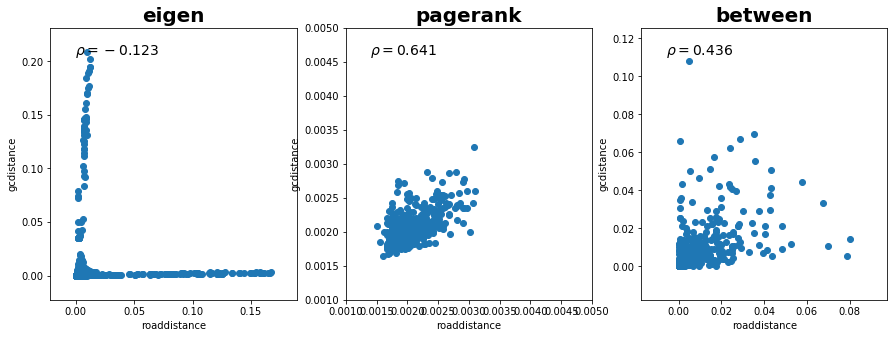

In [20]:
cdf=combined_village_centrality_df[combined_village_centrality_df['k']==20]
centmeasure1='eigen'
centmeasure2='pagerank'
centmeasure3='between'

x=cdf[cdf['disttype']=='roaddistance'][centmeasure1]
z=cdf[cdf['disttype']=='gcdistance'][centmeasure1]

xx=cdf[cdf['disttype']=='roaddistance'][centmeasure2]
zz=cdf[cdf['disttype']=='gcdistance'][centmeasure2]

xxx=cdf[cdf['disttype']=='roaddistance'][centmeasure3]
zzz=cdf[cdf['disttype']=='gcdistance'][centmeasure3]

plt.close()
f,aa=plt.subplots(1,3,figsize=(15,5))


a=aa[0]
a.scatter(x,z)
a.set_xlabel('roaddistance')
a.set_ylabel('gcdistance')
a.set_title(centmeasure1,fontsize=20,fontweight='bold')
r2,_=stats.pearsonr(x,z)
a.text(s=r'$\rho={:.3f}$'.format(r2),x=.1,y=.9,transform=a.transAxes,fontsize=14)



a=aa[1]
a.scatter(xx,zz)
a.set_xlim([.001,.005])
a.set_ylim([.001,.005])
r2,_=stats.pearsonr(xx,zz)
a.text(s=r'$\rho={:.3f}$'.format(r2),x=.1,y=.9,transform=a.transAxes,fontsize=14)
a.set_xlabel('roaddistance')
a.set_ylabel('gcdistance')
a.set_title(centmeasure2,fontsize=20,fontweight='bold')


a=aa[2]
a.scatter(xxx,zzz)
# a.set_xlim([.001,.005])
# a.set_ylim([.001,.005])
r2,_=stats.pearsonr(xxx,zzz)
a.text(s=r'$\rho={:.3f}$'.format(r2),x=.1,y=.9,transform=a.transAxes,fontsize=14)
a.set_xlabel('roaddistance')
a.set_ylabel('gcdistance')
a.set_title(centmeasure3,fontsize=20,fontweight='bold')


plt.show()
                                              
                                              

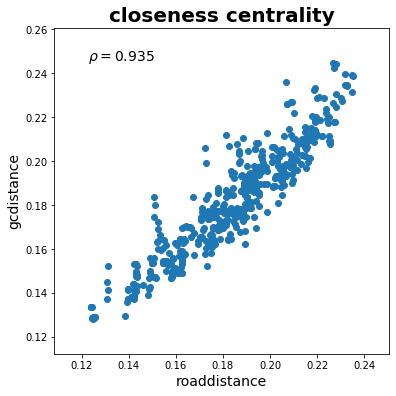

In [21]:
cdf=combined_village_centrality_df[combined_village_centrality_df['k']==20]

x=cdf[cdf['disttype']=='roaddistance']['closeness_weight']
y=cdf[cdf['disttype']=='riverdistance']['closeness_weight']
z=cdf[cdf['disttype']=='gcdistance']['closeness_weight']

plt.close()
f,a=plt.subplots(1,1,figsize=(6,6))

a.scatter(x,z)
a.set_xlabel('roaddistance',fontsize=14)
a.set_ylabel('gcdistance',fontsize=14)
a.set_title('closeness centrality',fontsize=20,fontweight='bold')
r2,_=stats.pearsonr(x,z)
a.text(s=r'$\rho={:.3f}$'.format(r2),x=.1,y=.9,transform=a.transAxes,fontsize=14)

plt.show()
                                              
                                              

## Compute correlation coefficient/linear regression on centrality measures

In [22]:
centrality_cols=['between','between_weight','closeness',
                 'closeness_weight','degree','eigen','eigen_weight',
                 'pagerank']
F_inds=['Finbd_gcdist','Finbd_roaddist']
dist_type2f_ind=dict(zip(['gcdistance','roaddistance'],
                        ['Finbd_gcdist','Finbd_roaddist']))
other_cov=['incidence','urban']


Corr_pval_df=pd.DataFrame()

#some of the villages are not in the metadata. we just filter these out 
# ind2keep=np.where(combined_village_centrality_df['vid'].astype(int).isin(meta_data.index.values))[0]
#villages that have zero incidence.
# ind2keep=meta_data.index[np.where(~meta_data['incidence'].isna())[0]]
# 
# combined_village_centrality_df=combined_village_centrality_df.iloc[ind2keep,:]

kvals=combined_village_centrality_df['k'].unique()
disttypes=combined_village_centrality_df['disttype'].unique()

for k in kvals:
    print(k)
    for disttype in disttypes:
        print(disttype,end=', ')
        for cent in centrality_cols:
            cdf=combined_village_centrality_df[ np.logical_and(combined_village_centrality_df['k']==k,
                                                                   combined_village_centrality_df['disttype']==disttype)]
            
            Fval=dist_type2f_ind[disttype] #only do matching types

            cdf['-log2FinBD']=-1*np.log2(cdf.loc[:,Fval])
            cdf=cdf.iloc[np.where(~cdf['-log2FinBD'].isna())[0],:]
            
            centvec=cdf.loc[:,cent]
            cfvec=cdf.loc[:,"-log2FinBD"]
            
            corr,_=stats.pearsonr(cdf['-log2FinBD'],centvec)

            X=cdf.loc[:,[cent]+other_cov]
            X=sm.add_constant(X)
            est=sm.OLS(cfvec,X).fit()

            summary=est.summary()
            results_as_html = summary.tables[1].as_html()
            sum_tab=pd.read_html(results_as_html,header=0,index_col=0)[0]

            cind=Corr_pval_df.shape[0]
            Corr_pval_df.loc[cind,'k']=k
            Corr_pval_df.loc[cind,'disttype']=disttype
            Corr_pval_df.loc[cind,'F_ind']=Fval
            Corr_pval_df.loc[cind,'centrality']=cent
            Corr_pval_df.loc[cind,'Pear_r']=corr
            Corr_pval_df.loc[cind,'lin_R2']=est.rsquared
            Corr_pval_df.loc[cind,'lin_pval_cent']=sum_tab.loc[cent,'P>|t|']
            Corr_pval_df.loc[cind,'lin_tval_cent']=sum_tab.loc[cent,'t']
            Corr_pval_df.loc[cind,'lin_fpval']=est.f_pvalue
                
    print()
            
        


20
roaddistance, 

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


gcdistance, 


In [23]:
Corr_pval_df.sort_values(by='Pear_r',ascending=False).iloc[:20,:]
# Corr_pval_df.sort_values(by='lin_tval_cent',ascending=False).iloc[:20,:]

,k,disttype,F_ind,centrality,Pear_r,lin_R2,lin_pval_cent,lin_tval_cent,lin_fpval
11,20.0,gcdistance,Finbd_gcdist,closeness_weight,0.391084,0.253680,0.000,8.012,6.780891e-22
10,20.0,gcdistance,Finbd_gcdist,closeness,0.383367,0.249524,0.000,7.868,1.762899e-21
3,20.0,roaddistance,Finbd_roaddist,closeness_weight,0.323164,0.222290,0.000,7.115,8.084988e-19
2,20.0,roaddistance,Finbd_roaddist,closeness,0.316253,0.219070,0.000,6.999,1.643900e-18
8,20.0,gcdistance,Finbd_gcdist,between,0.290698,0.186646,0.000,5.504,1.767528e-15
9,20.0,gcdistance,Finbd_gcdist,between_weight,0.281104,0.184697,0.000,5.422,2.663753e-15
0,20.0,roaddistance,Finbd_roaddist,between,0.160228,0.136783,0.001,3.353,4.629135e-11
4,20.0,roaddistance,Finbd_roaddist,degree,0.150799,0.121326,0.027,2.222,9.503750e-10
12,20.0,gcdistance,Finbd_gcdist,degree,0.144857,0.133833,0.007,2.700,8.280609e-11
15,20.0,gcdistance,Finbd_gcdist,pagerank,0.140521,0.129809,0.018,2.378,1.823588e-10


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


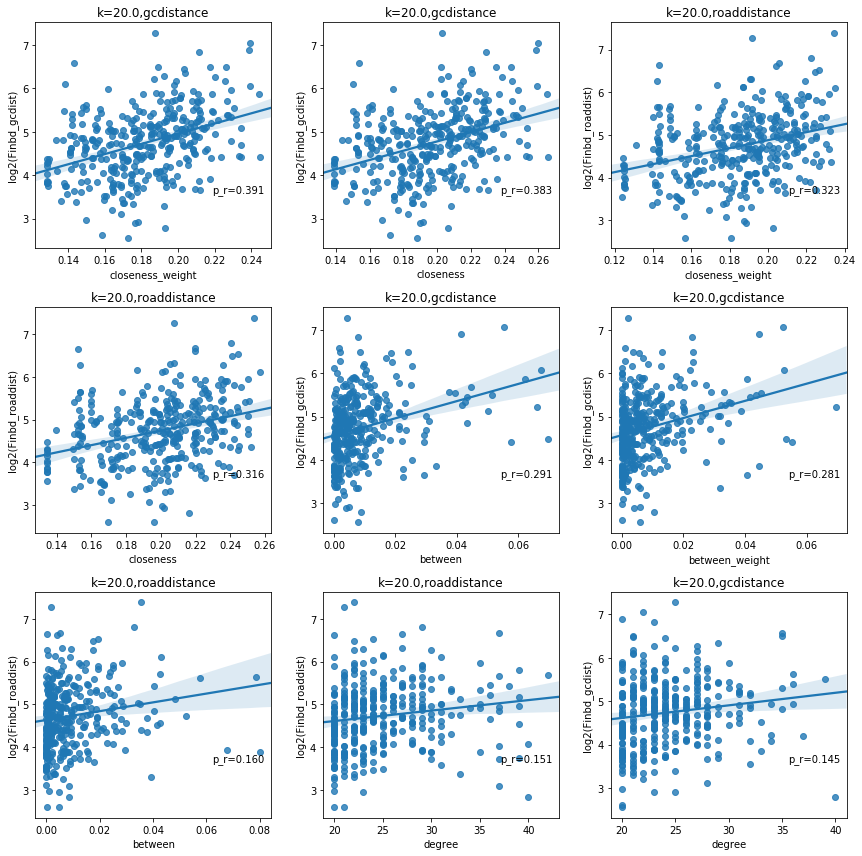

In [24]:
top_vals=Corr_pval_df.sort_values(by='Pear_r',ascending=False).iloc[:9,:]
# top_vals=Corr_pval_df.sort_values(by='lin_tval_cent',ascending=False).iloc[:9,:]

plt.close()
f,a=plt.subplots(3,3,figsize=(12,12))

for i,ind in enumerate(top_vals.index):
    
    a=plt.subplot(3,3,i+1)
    k,disttype,F_ind,cent=top_vals.loc[ind,['k','disttype','F_ind','centrality']]
    
    cdf=combined_village_centrality_df[ np.logical_and(combined_village_centrality_df['k']==k,
                                                                   combined_village_centrality_df['disttype']==disttype)]
    
    cdf['-log2FinBD']=-1*np.log2(cdf.loc[:,F_ind])
    cdf=cdf.iloc[np.where(~cdf['-log2FinBD'].isna())[0],:]
    
    cfvec=cdf.loc[:,'-log2FinBD']
    cent_vec=cdf.loc[:,cent]
    
#     a.scatter(cent_vec,cfvec)
    sbn.regplot(cent_vec,cfvec)
    a.set_title("k={:},{:}".format(k,disttype))
    a.set_ylabel("log2({:})".format(F_ind))
    a.set_xlabel(cent)
    r,_=stats.pearsonr(cent_vec,cfvec)
    a.text(s='p_r={:.3f}'.format(r),x=.75,y=.25,transform=a.transAxes)
#     a.set_xscale('symlog',linthreshx=.001)

f.tight_layout()
plt.show()

In [25]:
Corr_pval_df.head()

,k,disttype,F_ind,centrality,Pear_r,lin_R2,lin_pval_cent,lin_tval_cent,lin_fpval
0,20.0,roaddistance,Finbd_roaddist,between,0.160228,0.136783,0.001,3.353,4.629135e-11
1,20.0,roaddistance,Finbd_roaddist,between_weight,0.129909,0.130514,0.003,2.942,1.588464e-10
2,20.0,roaddistance,Finbd_roaddist,closeness,0.316253,0.219070,0.000,6.999,1.643900e-18
3,20.0,roaddistance,Finbd_roaddist,closeness_weight,0.323164,0.222290,0.000,7.115,8.084988e-19
4,20.0,roaddistance,Finbd_roaddist,degree,0.150799,0.121326,0.027,2.222,9.503750e-10


In [26]:

top_corss=Corr_pval_df.loc[Corr_pval_df.groupby(['disttype','centrality'])['Pear_r'].idxmax().values,:]
top_corss.loc[top_corss['disttype'].isin(['gcdistance','roaddistance']),:].sort_values(by='Pear_r',ascending=False)

,k,disttype,F_ind,centrality,Pear_r,lin_R2,lin_pval_cent,lin_tval_cent,lin_fpval
11,20.0,gcdistance,Finbd_gcdist,closeness_weight,0.391084,0.253680,0.000,8.012,6.780891e-22
10,20.0,gcdistance,Finbd_gcdist,closeness,0.383367,0.249524,0.000,7.868,1.762899e-21
3,20.0,roaddistance,Finbd_roaddist,closeness_weight,0.323164,0.222290,0.000,7.115,8.084988e-19
2,20.0,roaddistance,Finbd_roaddist,closeness,0.316253,0.219070,0.000,6.999,1.643900e-18
8,20.0,gcdistance,Finbd_gcdist,between,0.290698,0.186646,0.000,5.504,1.767528e-15
9,20.0,gcdistance,Finbd_gcdist,between_weight,0.281104,0.184697,0.000,5.422,2.663753e-15
0,20.0,roaddistance,Finbd_roaddist,between,0.160228,0.136783,0.001,3.353,4.629135e-11
4,20.0,roaddistance,Finbd_roaddist,degree,0.150799,0.121326,0.027,2.222,9.503750e-10
12,20.0,gcdistance,Finbd_gcdist,degree,0.144857,0.133833,0.007,2.700,8.280609e-11
15,20.0,gcdistance,Finbd_gcdist,pagerank,0.140521,0.129809,0.018,2.378,1.823588e-10


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


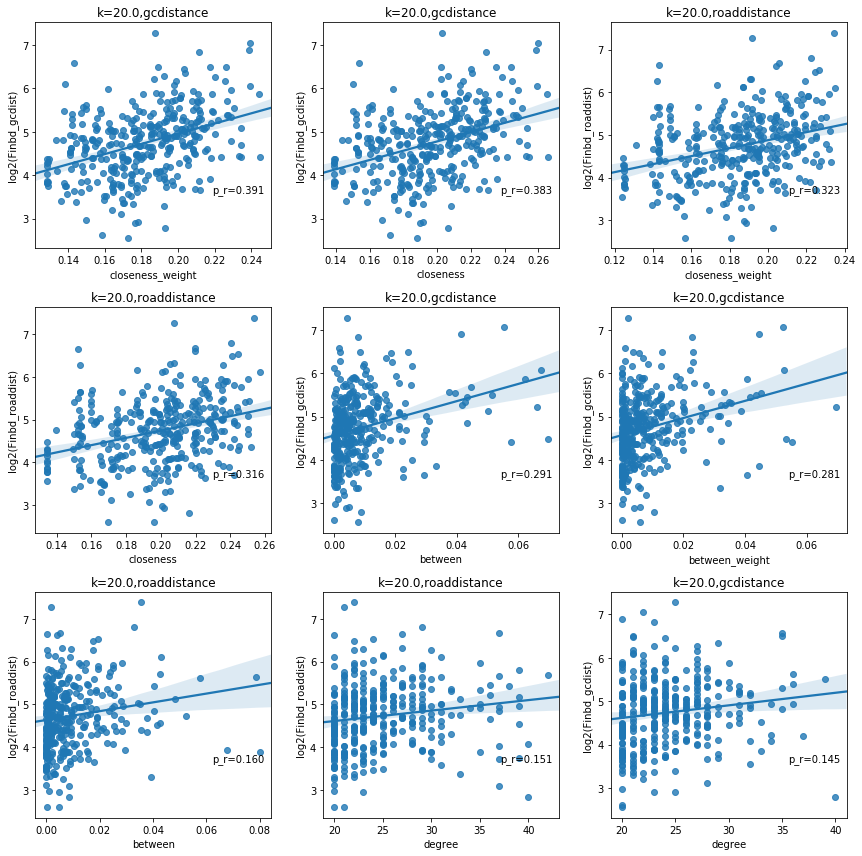

In [27]:
top_vals=Corr_pval_df.sort_values(by='Pear_r',ascending=False).iloc[:9,:]
# top_vals=Corr_pval_df.sort_values(by='lin_tval_cent',ascending=False).iloc[:9,:]

plt.close()
f,a=plt.subplots(3,3,figsize=(12,12))

for i,ind in enumerate(top_vals.index):
    
    a=plt.subplot(3,3,i+1)
    k,disttype,F_ind,cent=top_vals.loc[ind,['k','disttype','F_ind','centrality']]
    
    cdf=combined_village_centrality_df[ np.logical_and(combined_village_centrality_df['k']==k,
                                                                   combined_village_centrality_df['disttype']==disttype)]
    cdf['-log2FinBD']=-1*np.log2(cdf.loc[:,F_ind])
    cdf=cdf.iloc[np.where(~cdf['-log2FinBD'].isna())[0],:]
    
    cfvec=cdf.loc[:,'-log2FinBD']
    cent_vec=cdf.loc[:,cent]
#     a.scatter(cent_vec,cfvec)
    sbn.regplot(cent_vec,cfvec)
    a.set_title("k={:},{:}".format(k,disttype))
    a.set_ylabel("log2({:})".format(F_ind))
    a.set_xlabel(cent)
    r,_=stats.pearsonr(cent_vec,cfvec)
    a.text(s='p_r={:.3f}'.format(r),x=.75,y=.25,transform=a.transAxes)
#     a.set_xscale('symlog',linthreshx=.001)

f.tight_layout()
plt.show()

## Plot graphs colored by centrality

In [28]:
village_graphs_by_disttype

{'roaddistance': {20: <Graph object, undirected, with 491 vertices and 6151 edges at 0x10dc70358>},
 'gcdistance': {20: <Graph object, undirected, with 491 vertices and 5973 edges at 0x14dbca278>}}

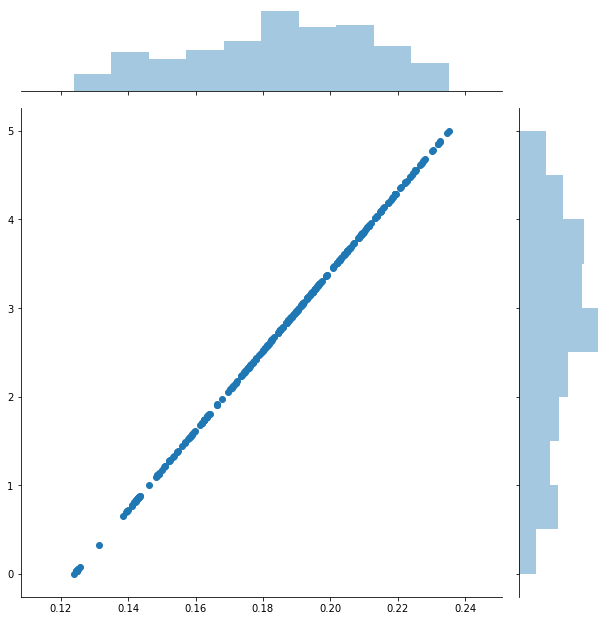

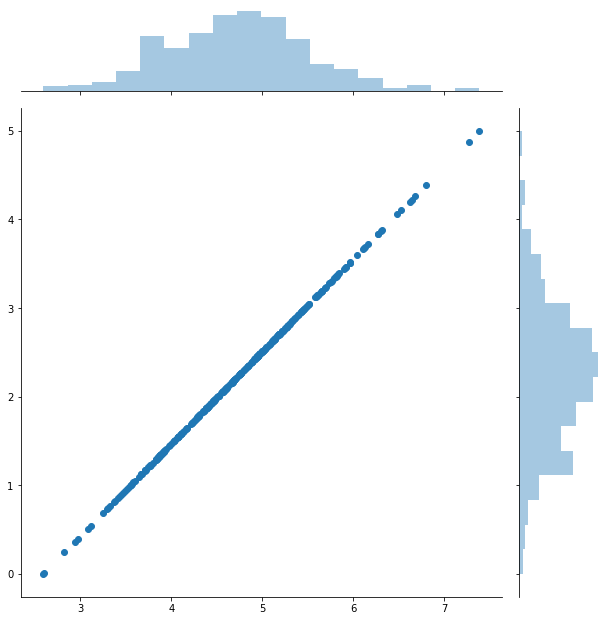

In [32]:
#here we add in the color property.  we also apply transformation to the 
#property we are trying to show to better disply differences.
k2use=20
# disttype2use='roaddistance'
# disttype2use='riverdistance'

disttype2use='roaddistance'

centrality='closeness_weight'
f_ind='Finbd_roaddist'

graph_gt=village_graphs_by_disttype[disttype2use][k2use]

#filter out nodes 
graph_gt.vp['filt']=graph_gt.new_vp('bool')
graph_gt.vp['filt'].a=np.logical_not(np.isnan(graph_gt.vp['incidence'].a))
graph_gt=gt.Graph(gt.GraphView(graph_gt,vfilt=graph_gt.vp['filt']),prune=True)

cent_array=np.array(graph_gt.vp[centrality].a)


incidence=np.array(graph_gt.vp['incidence'].a)
plt.close()

# f,a=plt.subplots(1,1,figsize=(8,8))
x=cent_array
tran_vp=gt.draw.prop_to_size(graph_gt.vp[centrality],power=1,log=False)
graph_gt.vp['color_trans']=tran_vp
trans_array=np.array(tran_vp.a)

g=sbn.jointplot(x=x, y=trans_array)
f=plt.gcf()
f.set_size_inches(9,9)
plt.show()

cmap=sbn.cubehelix_palette(as_cmap=True)

norm = mc.Normalize(vmin=trans_array.min(),
                                   vmax=trans_array.max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
colors=np.array(list(map(lambda x : mapper.to_rgba(x) ,trans_array)))

graph_gt.vp['color']=graph_gt.new_vp('vector<float>')
graph_gt.vp['color'].set_2d_array(colors.T)



#colors for the second plot based on Find 

plt.close()

# f,a=plt.subplots(1,1,figsize=(8,8))
f_ind_array=-1*np.log2(np.array(graph_gt.vp[f_ind].a))

graph_gt.vp['log2_'+f_ind]=graph_gt.new_vp('float')
graph_gt.vp['log2_'+f_ind].a=f_ind_array
tran_vp2=gt.draw.prop_to_size(graph_gt.vp['log2_'+f_ind],power=1,log=False)
trans_array2=np.array(tran_vp2.a)

g=sbn.jointplot(x=f_ind_array, y=trans_array2)
f=plt.gcf()
f.set_size_inches(9,9)
plt.show()


cmap=sbn.cubehelix_palette(as_cmap=True)
norm = mc.Normalize(vmin=trans_array2.min(),
                                   vmax=trans_array2.max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
colors2=np.array(list(map(lambda x : mapper.to_rgba(x) ,trans_array2)))
graph_gt.vp['color2']=graph_gt.new_vp('vector<float>')
graph_gt.vp['color2'].set_2d_array(colors2.T)

graph_gt=nt.visualization.run_fa2_on_gt_network(graph_gt,scale=100,stronger_gravity=True,gravity=.1,niter=100)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.


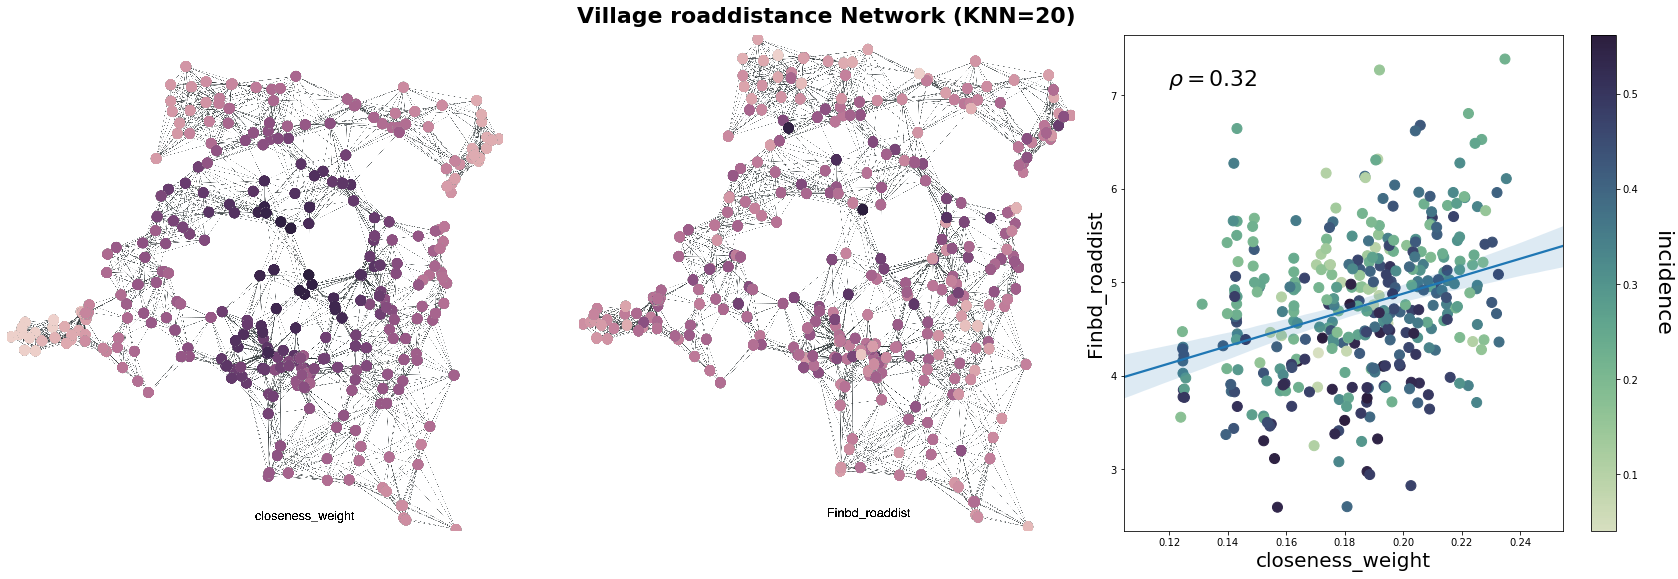

In [33]:
outfile=os.path.join(graphics_dir,'road_knn{:d}_combined.png'.format(k2use))
graph_img=os.path.join(graphics_dir,'village_knn{:d}_{:}_{:}.png'.format(k2use,disttype2use,centrality))
graph_img2=os.path.join(graphics_dir,'village_knn{:d}_{:}_{:}.png'.format(k2use,disttype2use,f_ind))

plt.switch_backend('cairo')
f,a=plt.subplots(1,1,figsize=(12,12))
gtd.graph_draw(g=graph_gt,
               vertex_fill_color=graph_gt.vp['color'],
               vertex_size=55,
               pos=graph_gt.vp['geo_coords'],mplfig=a)
a.set_axis_off()
f.subplots_adjust(top=1.03,bottom=-.09,right=1.09,left=-.09)
# a.text(s='Village {:} Road Network (KNN={:d})'.format(disttype2use,k2use),x=.5,y=.93,transform=a.transAxes,horizontalalignment='center',
#        fontsize=30,fontweight='bold')
a.text(s='{:}'.format(centrality),x=.5,y=.1,fontsize=22,fontweight='bold',transform=a.transAxes)

f.savefig(graph_img,dpi=200)
plt.show()
#plot the second layout
plt.close()
f,a=plt.subplots(1,1,figsize=(12,12))
gtd.graph_draw(g=graph_gt,
               vertex_fill_color=graph_gt.vp['color2'],
               vertex_size=55,
               pos=graph_gt.vp['geo_coords'],mplfig=a)
a.set_axis_off()
f.subplots_adjust(top=1.09,bottom=-.09,right=1.09,left=-.09)


a.text(s='{:}'.format(f_ind),x=.5,y=.1,fontsize=22,fontweight='bold',transform=a.transAxes)
f.savefig(graph_img2,dpi=200)
plt.show()

plt.switch_backend('module://ipykernel.pylab.backend_inline')
plt.close()

f=plt.gcf()
f.set_size_inches((24,8))

a=plt.subplot2grid((1,3),(0,0),colspan=1,rowspan=1)
im=mpimg.imread(graph_img)
a.set_axis_off()
plt.imshow(im)

a=plt.subplot2grid((1,3),(0,1),colspan=1,rowspan=1)
im=mpimg.imread(graph_img2)
a.set_axis_off()
plt.imshow(im)

a=plt.subplot2grid((1,3),(0,2),colspan=1,rowspan=1)
r2,_=stats.pearsonr(cent_array,f_ind_array)
cmap=sbn.cubehelix_palette( start=.5, rot=-.75,as_cmap=True)

sc=a.scatter(cent_array,f_ind_array,cmap=cmap,c=incidence,s=100)
plt.colorbar(sc,ax=a)
sbn.regplot(cent_array,f_ind_array,scatter=False,ax=a)

a.set_xlabel(centrality,fontsize=20)
a.set_ylabel(f_ind,fontsize=20)
a.text(s=r'$\rho={:.2f}$'.format(r2),x=.1,y=.9,transform=a.transAxes,fontsize=22)
a.text(s='incidence',rotation=-90,x=1.2,y=.5,verticalalignment='center',fontsize=22,
       transform=a.transAxes)

f.suptitle(t='Village {:} Network (KNN={:d})'.format(disttype2use,k2use),x=.5,y=.99,
       transform=f.transFigure,horizontalalignment='center',
       fontsize=22,fontweight='bold')

f.subplots_adjust(top=.94,bottom=.08,right=.99,left=.01,hspace=0,wspace=.04)

f.savefig(outfile,dpi=200)
plt.show()

In [31]:
other_cov=['incidence','urban']
cdf=combined_village_centrality_df[ np.logical_and(combined_village_centrality_df['k']==k2use,
                                                                   combined_village_centrality_df['disttype']==disttype2use)]


cdf['-log2FinBD']=-1*np.log2(cdf.loc[:,F_ind])
cdf=cdf.iloc[np.where(~cdf['-log2FinBD'].isna())[0],:]

cfvec=cdf.loc[:,'-log2FinBD']
cent_vec=cdf.loc[:,cent]
corr,_=stats.pearsonr(cent_vec,cfvec)

X=cdf.loc[:,[centrality]+other_cov]
X=sm.add_constant(X)
est=sm.OLS(cfvec,X).fit()

summary=est.summary()
summary
    
    

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             -log2FinBD   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     39.32
Date:                Sat, 26 Sep 2020   Prob (F-statistic):           6.78e-22
Time:                        16:55:44   Log-Likelihood:                -361.53
No. Observations:                 351   AIC:                             731.1
Df Residuals:                     347   BIC:                             746.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.2829      0.302     10.880      0.000       2.689       3.876
closeness_weight    11.5081      1.436      8.012      0.000       8.683      14.333
incidence           -1.9450      0.301     -6.464      0.000      -2.537      -1.353
urban                0.0076      0.015      0.506      0.613      -0.022       0.037
==============================================================================
Omnibus:                        1.691   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.491
Skew:                           0.065   Prob(JB):                        0.474
Kurtosis:                       3.291   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Animation of KNN graphs

In [135]:
#animation of gcdistance
anim_image_dir=os.path.join(graphics_dir,"anmiation_gcdistance")
if not os.path.exists(anim_image_dir):
    os.makedirs(anim_image_dir)

distancetypes=['gcdistance']
disttype='gcdistance'
centrality='closeness_weight'
print(disttype)
dist_adj_long[disttype+'_norm']=dist_adj_long[disttype]/dist_adj_long[disttype].max()
village_dist=dist_adj_long.groupby(['hv001.x','hv001.y'])[disttype+'_norm'].max().unstack(fill_value=0)

#ensure that the set of columns and rows are the same 
missinds=village_dist.index[np.logical_not(village_dist.index.isin(village_dist.columns))]
for ind in missinds:
    village_dist.loc[:,ind]=village_dist.loc[ind,:]
misscols=village_dist.columns[np.logical_not(village_dist.columns.isin(village_dist.index))]
for col in misscols:
    village_dist.loc[col,:]=village_dist.loc[:,col]
village_dist=village_dist.loc[:,village_dist.index]   
#symetric distances
village_dist=village_dist+village_dist.T

kvals=list(range(1,50))#+[-1]
# kvals=[-1]
all_anim_images=[]
for k in kvals:
    print(k)
    knn_adj=create_knn_from_distmat(village_dist.values,
                                   k=k,weight_func=lambda x: np.exp(-x) )

#         knn_adj=create_knn_from_distmat(village_dist.values,
#                                        k=k,weight_func=None)

    cgraph=nt.create_gt_graph_from_adj(knn_adj)
    cgraph.vp['vid']=cgraph.new_vp('string')
    cgraph.vp['vid'].set_2d_array(village_dist.index)

    v_ids=cgraph.vp['vid'].get_2d_array([0])[0]

    #add in geo_coords
    cgraph.vp['geo_coords']=cgraph.new_vp('vector<float>')
    cgraph.vp['geo_coords'].set_2d_array(vil_coords.loc[v_ids.astype(int),:].values.T)

    for key in feat_dicts.keys():
        cvals=np.array(list(map(lambda x: feat_dicts[key].get(int(x),0),v_ids)))
        try:
            cgraph.vp[key]=cgraph.new_vp('float')
            cgraph.vp[key].set_2d_array(cvals)
        except:
            pass

    #distance for the betweenness/closeness centrality calculations if weighted n
    cgraph.ep['dist']=cgraph.new_ep('float')
    gt.map_property_values(src_prop=cgraph.ep['weight'],
                                             tgt_prop=cgraph.ep['dist'],
                                            map_func=lambda x: 1.0/x)
    
    cclose=gtc.closeness(cgraph)
    cclose_w=gtc.closeness(cgraph,weight=cgraph.ep['dist'])
    cgraph.vp['closeness']=cclose
    cgraph.vp['closeness_weight']=cclose_w
    
    
    
    cent_array=np.array(cgraph.vp[centrality].a)

    x=cent_array
    tran_vp=gt.draw.prop_to_size(cgraph.vp[centrality],power=1,log=False)
    cgraph.vp['color_trans']=tran_vp
    trans_array=np.array(tran_vp.a)


    cmap=sbn.cubehelix_palette(as_cmap=True)

    norm = mc.Normalize(vmin=trans_array.min(),
                                       vmax=trans_array.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors=np.array(list(map(lambda x : mapper.to_rgba(x) ,trans_array)))

    cgraph.vp['color']=cgraph.new_vp('vector<float>')
    cgraph.vp['color'].set_2d_array(colors.T)
    
    
    outfile=os.path.join(anim_image_dir,'gcdistance_knn={:d}.png'.format(k))
    all_anim_images.append(outfile)
    plt.switch_backend('cairo')
    plt.close()
    f,a=plt.subplots(1,1,figsize=(12,12))
    gtd.graph_draw(g=cgraph,
                   vertex_fill_color=cgraph.vp['color'],
                   vertex_size=40,
                   pos=cgraph.vp['geo_coords'],mplfig=a)
    a.set_axis_off()
    f.subplots_adjust(top=1.05,bottom=-.05,right=1.05,left=-.05)

    a.text(s='k={:}'.format(k),x=.5,y=.1,fontsize=22,fontweight='bold',transform=a.transAxes)

    f.savefig(outfile,dpi=150)
    plt.close()

final_gif=os.path.join(datadir,"networks/village_networks","gc_knn_animation.gif")
imaged_loaded=[]
for filename in all_anim_images:
    imaged_loaded.append(imageio.imread(filename))
imageio.mimsave(final_gif, imaged_loaded)



gcdistance
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [52]:
anim_image_dir=os.path.join(datadir,"networks/village_networks/anmiation_roaddistance")
if not os.path.exists(anim_image_dir):
    os.makedirs(anim_image_dir)

distancetypes=['roaddistance']
disttype='roaddistance'
centrality='closeness_weight'
print(disttype)
dist_adj_long[disttype+'_norm']=dist_adj_long[disttype]/dist_adj_long[disttype].max()
village_dist=dist_adj_long.groupby(['hv001.x','hv001.y'])[disttype+'_norm'].max().unstack(fill_value=0)

#ensure that the set of columns and rows are the same 
missinds=village_dist.index[np.logical_not(village_dist.index.isin(village_dist.columns))]
for ind in missinds:
    village_dist.loc[:,ind]=village_dist.loc[ind,:]
misscols=village_dist.columns[np.logical_not(village_dist.columns.isin(village_dist.index))]
for col in misscols:
    village_dist.loc[col,:]=village_dist.loc[:,col]
village_dist=village_dist.loc[:,village_dist.index]   
#symetric distances
village_dist=village_dist+village_dist.T

kvals=list(range(1,50))#+[-1]
# kvals=[-1]
all_anim_images=[]
for k in kvals:
    if k%2==0:
        print(k)
    knn_adj=create_knn_from_distmat(village_dist.values,
                                   k=k,weight_func=lambda x: np.exp(-x) )

#         knn_adj=create_knn_from_distmat(village_dist.values,
#                                        k=k,weight_func=None)

    cgraph=nt.create_gt_graph_from_adj(knn_adj)
    cgraph.vp['vid']=cgraph.new_vp('string')
    cgraph.vp['vid'].set_2d_array(village_dist.index)

    v_ids=cgraph.vp['vid'].get_2d_array([0])[0]

    #add in geo_coords
    cgraph.vp['geo_coords']=cgraph.new_vp('vector<float>')
    cgraph.vp['geo_coords'].set_2d_array(vil_coords.loc[v_ids.astype(int),:].values.T)

    for key in feat_dicts.keys():
        cvals=np.array(list(map(lambda x: feat_dicts[key].get(int(x),0),v_ids)))
        cgraph.vp[key]=cgraph.new_vp('float')
        cgraph.vp[key].set_2d_array(cvals)

    #distance for the betweenness/closeness centrality calculations if weighted n
    cgraph.ep['dist']=cgraph.new_ep('float')
    gt.map_property_values(src_prop=cgraph.ep['weight'],
                                             tgt_prop=cgraph.ep['dist'],
                                            map_func=lambda x: 1.0/x)
    
    cclose=gtc.closeness(cgraph)
    cclose_w=gtc.closeness(cgraph,weight=cgraph.ep['dist'])
    cgraph.vp['closeness']=cclose
    cgraph.vp['closeness_weight']=cclose_w
    
    
    
    cent_array=np.array(cgraph.vp[centrality].a)

    x=cent_array
    tran_vp=gt.draw.prop_to_size(cgraph.vp[centrality],power=1,log=False)
    cgraph.vp['color_trans']=tran_vp
    trans_array=np.array(tran_vp.a)


    cmap=sbn.cubehelix_palette(as_cmap=True)

    norm = mc.Normalize(vmin=trans_array.min(),
                                       vmax=trans_array.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors=np.array(list(map(lambda x : mapper.to_rgba(x) ,trans_array)))

    cgraph.vp['color']=cgraph.new_vp('vector<float>')
    cgraph.vp['color'].set_2d_array(colors.T)
    
    
    outfile=os.path.join(anim_image_dir,'roaddistance_knn={:d}.png'.format(k))
    all_anim_images.append(outfile)
    plt.switch_backend('cairo')
    plt.close()
    f,a=plt.subplots(1,1,figsize=(12,12))
    gtd.graph_draw(g=cgraph,
                   vertex_fill_color=cgraph.vp['color'],
                   vertex_size=40,
                   pos=cgraph.vp['geo_coords'],mplfig=a)
    a.set_axis_off()
    f.subplots_adjust(top=1.05,bottom=-.05,right=1.05,left=-.05)

    a.text(s='k={:}'.format(k),x=.5,y=.1,fontsize=22,fontweight='bold',transform=a.transAxes)

    f.savefig(outfile,dpi=150)
    plt.close()

final_gif=os.path.join(datadir,"networks/village_networks","roaddistance_knn_animation.gif")
imaged_loaded=[]
for filename in all_anim_images:
    imaged_loaded.append(imageio.imread(filename))
imageio.mimsave(final_gif, imaged_loaded)



roaddistance
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48


# Compare Centralities

roaddistance
10


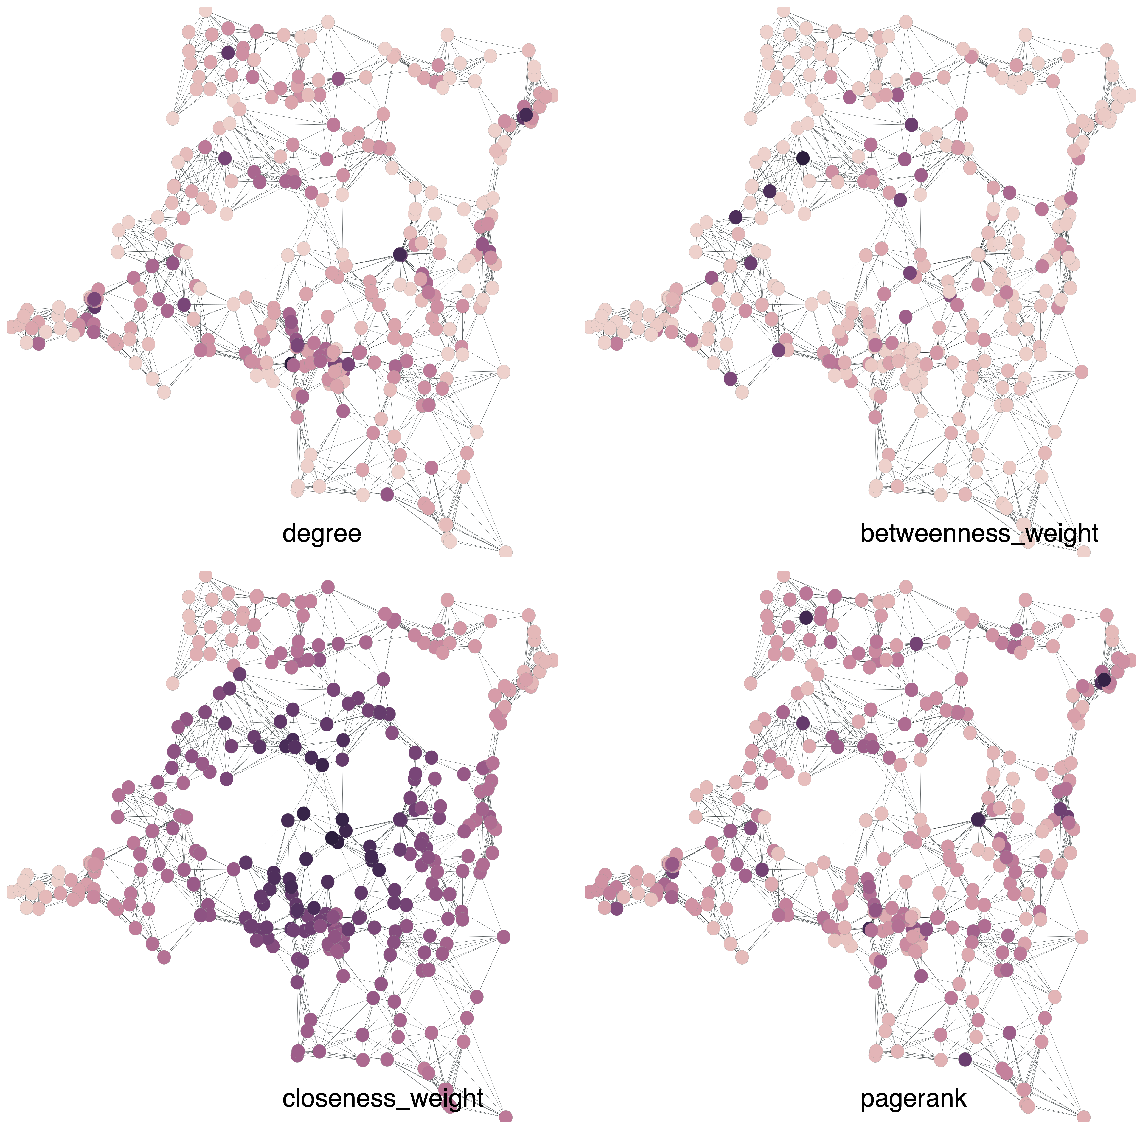

In [58]:
outfile=os.path.join(graphics_dir,'combined_knn{:d}_graph_allcentralities.png')
image_dir=os.path.join(graphics_dir,"centality_graphs_roaddistance")
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
image_files=[]

k=10
centralities=['degree','betweenness_weight','closeness_weight','pagerank']

disttype='roaddistance'
print(disttype)
dist_adj_long[disttype+'_norm']=dist_adj_long[disttype]/dist_adj_long[disttype].max()
village_dist=dist_adj_long.groupby(['hv001.x','hv001.y'])[disttype+'_norm'].max().unstack(fill_value=0)

#ensure that the set of columns and rows are the same 
missinds=village_dist.index[np.logical_not(village_dist.index.isin(village_dist.columns))]
for ind in missinds:
    village_dist.loc[:,ind]=village_dist.loc[ind,:]
misscols=village_dist.columns[np.logical_not(village_dist.columns.isin(village_dist.index))]
for col in misscols:
    village_dist.loc[col,:]=village_dist.loc[:,col]
village_dist=village_dist.loc[:,village_dist.index]   
#symetric distances
village_dist=village_dist+village_dist.T

all_anim_images=[]

print(k)
knn_adj=create_knn_from_distmat(village_dist.values,
                               k=k,weight_func=lambda x: np.exp(-x) )

#         knn_adj=create_knn_from_distmat(village_dist.values,
#                                        k=k,weight_func=None)

cgraph=nt.create_gt_graph_from_adj(knn_adj)
cgraph.vp['vid']=cgraph.new_vp('string')
cgraph.vp['vid'].set_2d_array(village_dist.index)

v_ids=cgraph.vp['vid'].get_2d_array([0])[0]

#add in geo_coords
cgraph.vp['geo_coords']=cgraph.new_vp('vector<float>')
cgraph.vp['geo_coords'].set_2d_array(vil_coords.loc[v_ids.astype(int),:].values.T)

for key in feat_dicts.keys():
    cvals=np.array(list(map(lambda x: feat_dicts[key].get(int(x),0),v_ids)))
    cgraph.vp[key]=cgraph.new_vp('float')
    cgraph.vp[key].set_2d_array(cvals)

#distance for the betweenness/closeness centrality calculations if weighted n
cgraph.ep['dist']=cgraph.new_ep('float')
gt.map_property_values(src_prop=cgraph.ep['weight'],
                                         tgt_prop=cgraph.ep['dist'],
                                        map_func=lambda x: 1.0/x)

cpr=gtc.pagerank(cgraph)
cbtw,_=gtc.betweenness(cgraph)
cbtw_w,_=gtc.betweenness(cgraph,weight=cgraph.ep['dist'])
cclose=gtc.closeness(cgraph)
cclose_w=gtc.closeness(cgraph,weight=cgraph.ep['dist'])
_,ceigen=gtc.eigenvector(cgraph)
_,ceigen_weight=gtc.eigenvector(cgraph,weight=cgraph.ep['weight'])
katz=gtc.katz(cgraph,weight=cgraph.ep['weight'])
cdegs=cgraph.degree_property_map('total')

cgraph.vp['degree']=cdegs
cgraph.vp['pagerank']=cpr
cgraph.vp['eigen']=ceigen
cgraph.vp['closeness']=cclose
cgraph.vp['closeness_weight']=cclose_w
cgraph.vp['betweenness']=cbtw
cgraph.vp['betweenness_weight']=cbtw_w

    
for centrality in centralities:
    cent_array=np.array(cgraph.vp[centrality].a)

    #set up colors for centrality
    x=cent_array
    tran_vp=gt.draw.prop_to_size(cgraph.vp[centrality],power=1,log=False)
    cgraph.vp['color_trans']=tran_vp
    trans_array=np.array(tran_vp.a)
    cmap=sbn.cubehelix_palette(as_cmap=True)
    norm = mc.Normalize(vmin=trans_array.min(),
                                       vmax=trans_array.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors=np.array(list(map(lambda x : mapper.to_rgba(x) ,trans_array)))
    cgraph.vp['color']=cgraph.new_vp('vector<float>')
    cgraph.vp['color'].set_2d_array(colors.T)
    
    outfile=os.path.join(image_dir,'roaddistance_knn={:d}_{:}.png'.format(k,centrality))
    image_files.append(outfile)

    plt.switch_backend('cairo')
    plt.close()
    f,a=plt.subplots(1,1,figsize=(12,12))
    gtd.graph_draw(g=cgraph,
                   vertex_fill_color=cgraph.vp['color'],
                   vertex_size=60,
                   pos=cgraph.vp['geo_coords'],mplfig=a)
    a.set_axis_off()
    f.subplots_adjust(top=1.09,bottom=-.09,right=1.09,left=-.09)

    a.text(s='{:}'.format(centrality),x=.5,y=.1,fontsize=40,fontweight='bold',transform=a.transAxes)
    
    f.savefig(outfile,dpi=200)
    plt.close()

combined_out=os.path.join(graphics_dir,"centality_graphs_roaddistance",'all_centralities_roaddistance_k{:d}.png'.format(k))
plt.switch_backend('module://ipykernel.pylab.backend_inline')
plt.close()
f=plt.gcf()
f.set_size_inches((16,16))
for i,centrality in enumerate(centralities):
    a=plt.subplot(2,2,i+1)
    im=mpimg.imread(image_files[i])
    a.set_axis_off()
    plt.imshow(im)



f.subplots_adjust(top=.99,bottom=.01,right=.99,left=.01,hspace=0,wspace=.05)

f.savefig(combined_out,dpi=200)
plt.show()

## Run champ to identify communities in the village network

In [ ]:
k=4
nruns=400
vgraph_ig=nt.building_network.convert_graph_tool_to_igraph(vill_graph_dict[k])
load=False

filename=os.path.join(datadir,'part_ens_village_network_k={:d}_nruns{:d}'.format(k,nruns))

if not load:
    part_ens=champ.parallel_leiden(vgraph_ig,start=0,fin=3,numruns=nruns,numprocesses=1,progress=True)
    part_ens.save(filename)
else:
    part_ens=champ.PartitionEnsemble()
    part_ens.load(filename)

In [ ]:
plt.close()
f,a=plt.subplots(1,2,figsize=(10,5))
a=plt.subplot(1,2,1)
part_ens.plot_modularity_mapping(ax=a,champ_only=True)

a=plt.subplot(1,2,2)
champ.plot_similarity_heatmap_single_layer(partitions=part_ens.partitions,
                                           index_2_domain=part_ens.ind2doms,ax=a,sim_mat=part_ens.sim_mat)
a.set_xlim([0,3])
a.set_ylim([0,3])

plt.show()

In [ ]:
broad_doms=part_ens.get_broadest_domains()
broad_doms['ncoms']=broad_doms['ind'].apply(lambda x: part_ens.numcoms[x])
broad_doms.head(10)

In [ ]:
ind2plot=3050
ind2plot=253
ind2plot=43
# part_ens.graph.vs['part_{:d}'.format(ind2plot)]=part_ens.partitions[ind2plot]
vgraph_ig=nt.building_network.convert_graph_tool_to_igraph(vill_graph_dict[4])
vgraph_ig.vs['part_{:d}'.format(ind2plot)]=part_ens.partitions[ind2plot]

village2com_dict=dict(zip(vgraph_ig.vs['vid'],vgraph_ig.vs['part_{:d}'.format(ind2plot)]))
# graph_gt=nt.convert_igraph_to_graph_tool(part_ens.graph)
graph_gt=nt.convert_igraph_to_graph_tool(vgraph_ig)

comvec=graph_gt.vp['part_{:d}'.format(ind2plot)].a
coms=np.unique(comvec)
cols=sbn.color_palette('cubehelix',n_colors=len(coms))
coldict=dict(zip(coms,cols))
colvec=np.array(list(map(lambda x: coldict[x],comvec)))
graph_gt.vp['color']=graph_gt.new_vp('vector<float>')
graph_gt.vp['color'].set_2d_array(colvec.T)
graph_gt=nt.visualization.run_fa2_on_gt_network(graph_gt,scale=100,stronger_gravity=True,gravity=.1,niter=100)
